In [2]:
import timeit
start_time = timeit.default_timer()
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.utils import save_image
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [3]:
nVar = 1

nTrain = 100000
nVal = 20000
nTest = nVal

x_train = torch.normal(5, 2, size=(nTrain, nVar))
x_val = torch.normal(5, 2, size=(nVal, nVar))
x_test = torch.normal(5, 2, size=(nTest, nVar))

In [4]:
batch_size = 100
trainloader = torch.utils.data.DataLoader(x_train, shuffle=True, batch_size=batch_size)
valloader = torch.utils.data.DataLoader(x_val, shuffle=False, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(x_test, shuffle=False, batch_size=batch_size)

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()      
        self.fc1 = nn.Linear(nVar, 128)  # E
        self.fc2 = nn.Linear(128, 128)   # E

        # Layers for our latent space distribution
        self.fc21 = nn.Linear(128, 8) # mu (μ, Média)
        self.fc22 = nn.Linear(128, 8) # sigma (σ, Desvio padrão)

        self.fc3 = nn.Linear(8, 128)     #  D
        self.fc31 = nn.Linear(128, 128)  #  D
        self.fc4 = nn.Linear(128, nVar)  #  D


    def encoder(self, x):
        h = torch.tanh(self.fc1(x))             # fc1, fc2... is acting like a function  because linear(x) triggers nn.Module.__call__  ????
#                                               # __call__ internally calls forward and manages autograd tracking.
        h = torch.tanh(self.fc2(h))
        return self.fc21(h), self.fc22(h)       # μ, σ 

    def sampling(self, mu, std):                # Reparameterization trick to sample from N(mu, std) from N(0,1)
        std = torch.exp(0.5 * std)
        eps = torch.randn_like(std)
        return mu + eps * std                   # Using two samples to compute expectation over z.

    def decoder(self, z):
        h = torch.tanh(self.fc3(z))
        return self.fc4(h)

    def forward(self, x):
        mu, std = self.encoder(x.view(-1, nVar))
        z = self.sampling(mu, std)
        return self.decoder(z), mu, std
    
model = VAE()
# if torch.cuda.is_available():
#     model.cuda()

In [ ]:
optimizer = torch.optim.Adam(
        model.parameters(),
        lr = 0.002
    )

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                                    'optimizer, 'max',
                                    factor=0.5,
                                    patience=5, threshold=0.001, cooldown=0,
                                    min_lr=0.0001, verbose=True
                                )

def loss_function(y, x, mu, std):
    loss = nn.MSELoss(reduction='sum')
    ERR = loss(y, x)
    KLD = -0.5 * torch.sum(1 + torch.log(std**2) - mu**2 - std**2)
    return ERR + KLD, -ERR, -KLD

c:\Users\vinic\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [28]:
count=0
err_l, kld_l, n_wu, terrl, tkldl, update = [], [], [], [], [], []
for epoch in range(1, 20):

    train_loss = 0
    for batch_idx, (data) in enumerate(trainloader):
        model.train()
        bsize = data.shape[0]
        recon_batch, mu, std = model(data)
        loss, err, kld = loss_function(recon_batch, data, mu, std)
        loss.backward()
        train_loss += err.item() + kld.item()
        optimizer.step()
        optimizer.zero_grad()
        err_l.append(err.item()/bsize)
        kld_l.append(kld.item()/bsize)
        count+=1
        n_wu.append(count)

        if (count%100 == 0): # Validating every 100 weight updates
          for batch_idx, datav in enumerate(valloader):
            model.eval()
            trecon, tmu, tstd = model(datav)
            tloss, terr, tkld = loss_function(trecon, datav, tmu, tstd)
            terrl.append(terr.item()/datav.shape[0])
            tkldl.append(tkld.item()/datav.shape[0])
            update.append(count)

    scheduler.step(train_loss / len(trainloader.dataset))

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(trainloader.dataset)))
    model.eval()
    test_loss= 0
    with torch.no_grad():
        for data in testloader:
            recon, mu, std = model(data)
            loss, err, kld = loss_function(recon, data, mu, std)
            test_loss += err + kld

    test_loss /= len(testloader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

====> Epoch: 1 Average loss: -2.5534
====> Test set loss: -1.4961
====> Epoch: 2 Average loss: -1.5375
====> Test set loss: -1.5040
====> Epoch: 3 Average loss: -1.5125
====> Test set loss: -1.4492
====> Epoch: 4 Average loss: -1.5081
====> Test set loss: -1.4720
====> Epoch: 5 Average loss: -1.5026
====> Test set loss: -1.4703
====> Epoch: 6 Average loss: -1.4851
====> Test set loss: -1.4663
====> Epoch: 7 Average loss: -1.5492
====> Test set loss: -1.5604
====> Epoch: 8 Average loss: -1.5073
====> Test set loss: -1.4928
====> Epoch: 9 Average loss: -1.4718
====> Test set loss: -1.4699
====> Epoch: 10 Average loss: -1.5937
====> Test set loss: -1.4684
====> Epoch: 11 Average loss: -1.4752
====> Test set loss: -1.4533
====> Epoch: 12 Average loss: -1.4855
====> Test set loss: -1.5171
====> Epoch: 13 Average loss: -1.4985
====> Test set loss: -1.7524
====> Epoch: 14 Average loss: -1.4684
====> Test set loss: -1.4496
====> Epoch: 15 Average loss: -1.4533
====> Test set loss: -1.5375
====

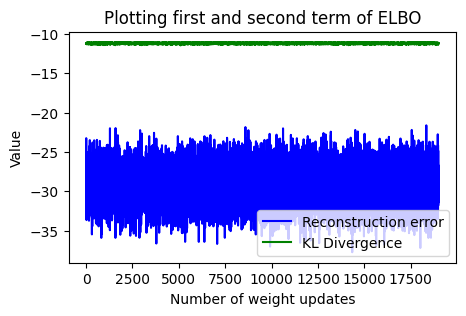

In [20]:
plt.figure(figsize=(5,3), dpi=100)
plt.plot(n_wu, err_l, 'b', label='Reconstruction error')
plt.plot(n_wu, kld_l, 'g', label='KL Divergence')
plt.title('Plotting first and second term of ELBO')
plt.xlabel('Number of weight updates')
plt.ylabel('Value')
plt.legend()

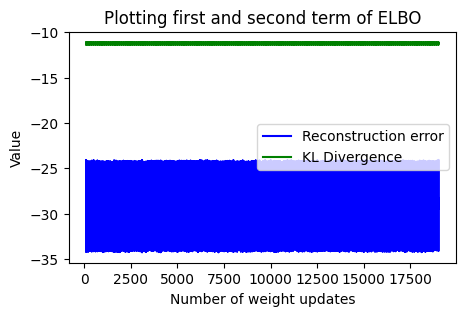

In [21]:
plt.figure(figsize=(5,3), dpi=100)
plt.plot(update, terrl, 'b', label='Reconstruction error')
plt.plot(update, tkldl, 'g', label='KL Divergence')
plt.title('Plotting first and second term of ELBO')
plt.xlabel('Number of weight updates')
plt.ylabel('Value')
plt.legend()

Aqui são geradas algumas amostras tentando reproduzir amostras do dataset de treino

(array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  1389., 81579., 17032.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.]),
 array([-3.        , -2.83999991, -2.68000007, -2.51999998, -2.3599999 ,
        -2.20000005, 

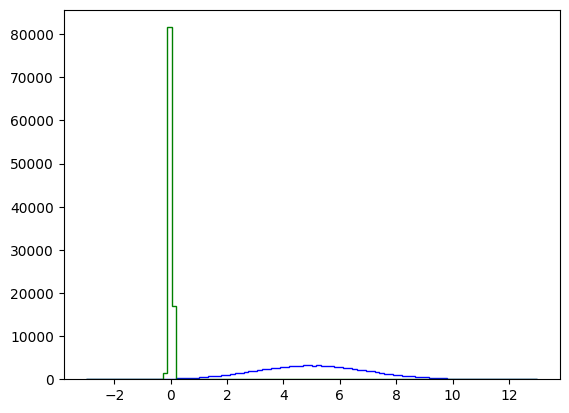

In [22]:
model.eval()
a = x_train
recon, mu, std = model(a)
b = recon
plt.hist(a[:,0], bins = 100, range = [-3,13], histtype = 'step', color = 'blue')
plt.hist(recon[:,0].detach().numpy(), bins = 100, range = [-3,13], histtype = 'step', color = 'green')

Aqui são geradas algumas amostras tentando reproduzir amostras do dataset de teste

(array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,   268., 16265.,  3467.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.]),
 array([-3.        , -2.83999991, -2.68000007, -2.51999998, -2.3599999 ,
        -2.20000005, 

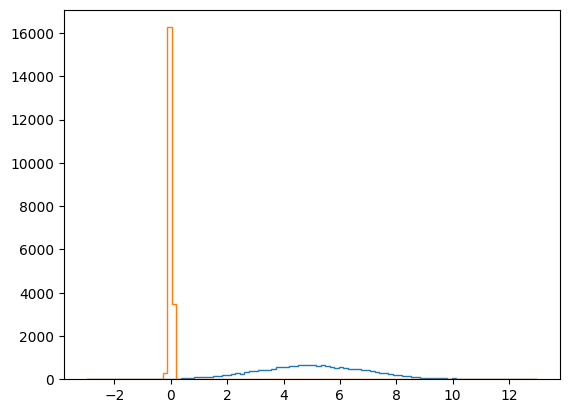

In [23]:
model.eval()
a = x_test
recon, mu, std = model(a)
b = recon
plt.hist(a[:,0], bins = 100, range = [-3,13], histtype = 'step')
plt.hist(recon[:,0].detach().numpy(), bins = 100, range = [-3,13], histtype = 'step')

E aqui são geradas algumas amostras partindo de valores aleatórios vindo de uma distribuição de Gaussiana padrão

torch.Size([20000, 1])


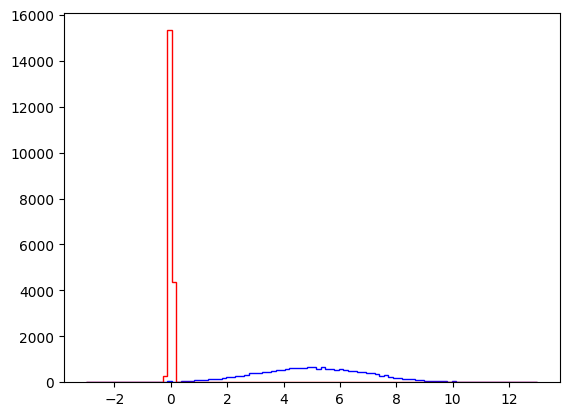

In [24]:
c = x_test
x = torch.randn(nTest,8)
d = model.decoder(x)
print(d.shape)
plt.hist(c[:,0], bins = 100, range = [-3,13], histtype = 'step', color = 'blue')
plt.hist(d[:,0].detach().numpy(), bins = 100, range = [-3,13], histtype = 'step', color = 'red')
elapsed = timeit.default_timer() - start_time

In [13]:
print(elapsed)

181.190563299926
